In [1]:
import pandas as pd 
import numpy as np
from langdetect import detect
# https://github.com/petrosDemetrakopoulos/RNN-Beatles-lyrics-generator
# https://github.com/starry91/Lyric-Generator#2-lyric-generator-based-on-word-level-rnn

In [2]:
#data = pd.read_csv("master-data.csv")

In [3]:
# Get rid of all rows whose lyrics column is NaN
#data = data[data['lyrics'].notnull()]
#non_strings = 0
#bad_indices = []
#for index, value in data['lyrics'].items():
 #   if type(value) != str:
  #      non_strings = non_strings + 1
   #     bad_indices.append(index)
#data[type(data['lyrics']) != str].shape 
#print(non_strings)
#print(data.shape)
#print(len(bad_indices))

In [4]:
#print(len(data['lyrics']))

In [5]:
def language_detector(string):
    global i
    try:
        res = detect(string)
    except:
        res = "undetectable"
    if i % 1000 == 0:
        print(i)
    i = i + 1
    return res

In [6]:
#i = 0
#data['language'] = data['lyrics'].apply(language_detector)

In [7]:
#data = data[data['language'] == "en"]

In [8]:
#data.to_csv("language-processed-data.csv")

In [9]:
data = pd.read_csv("language-processed-data.csv")

In [10]:
print(data.shape)
print(data.head())

(290515, 7)
   Unnamed: 0  Unnamed: 0.1           artist genre            title  \
0           0             0  beyonce-knowles   Pop        ego remix   
1           1             1  beyonce-knowles   Pop     then tell me   
2           2             2  beyonce-knowles   Pop          honesty   
3           3             3  beyonce-knowles   Pop  you are my rock   
4           4             4  beyonce-knowles   Pop    black culture   

                                              lyrics language  
0  Oh baby, how you doing?\nYou know I'm gonna cu...       en  
1  playin' everything so easy,\nit's like you see...       en  
2  If you search\nFor tenderness\nIt isn't hard t...       en  
3  Oh oh oh I, oh oh oh I\n[Verse 1:]\nIf I wrote...       en  
4  Party the people, the people the party it's po...       en  


## Prediction

- User inputs a song title, and how many words they want the song to be. 
- Network does, for example, 100 predictions, and in the training phrase we know what word we need to generate. 
- (genre, song title); have a marker that it's the end of the title 

## Character Level LSTM

Attempting a character level-RNN for a single genre
https://www.kaggle.com/super13579/let-s-auto-write-the-deep-purple-lysics-pytorch

In [189]:
data1 = data
data1['lyrics']= data1['lyrics'].apply(preprocessText)
print(data1.head())

   Unnamed: 0  Unnamed: 0.1           artist genre            title  \
0           0             0  beyonce-knowles   Pop        ego remix   
1           1             1  beyonce-knowles   Pop     then tell me   
2           2             2  beyonce-knowles   Pop          honesty   
3           3             3  beyonce-knowles   Pop  you are my rock   
4           4             4  beyonce-knowles   Pop    black culture   

                                              lyrics language  
0  oh baby how you doing?\nyou know i'm gonna cut...       en  
1  playin' everything so easy\nit's like you seem...       en  
2  if you search\nfor tenderness\nit isn't hard t...       en  
3  oh oh oh i oh oh oh i\nverse 1:\nif i wrote a ...       en  
4  party the people the people the party it's pop...       en  


In [190]:
data1.genre.unique()

array(['Pop', 'Hip-Hop', 'Not Available', 'Rock', 'Metal', 'Other',
       'Country', 'Jazz', 'Electronic', 'Folk', 'R&B', 'Indie', 'rap'],
      dtype=object)

In [192]:
data1 = data1[data1['genre'] == 'Country'].sample(100)

In [193]:
data1.shape

(100, 7)

In [194]:
DP_text = data1['lyrics'].str.cat(sep='\n').lower()
print('corpus length:', len(DP_text))

corpus length: 89524


In [195]:
# Counting characters appeared in all lyrics
chars = sorted(list(set(DP_text)))
print(chars)
print('total chars:', len(chars))

['\n', ' ', '!', '$', '&', "'", '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '\x97', '¹', 'á']
total chars: 49


In [196]:
# Create a dictionary of characters, see the index of characters.
char_to_int = dict((c, i) for i, c in enumerate(chars))
int_to_char = dict((i, c) for i, c in enumerate(chars))

print(char_to_int)

{'\n': 0, ' ': 1, '!': 2, '$': 3, '&': 4, "'": 5, '/': 6, '0': 7, '1': 8, '2': 9, '3': 10, '4': 11, '5': 12, '6': 13, '7': 14, '8': 15, '9': 16, ':': 17, ';': 18, '?': 19, 'a': 20, 'b': 21, 'c': 22, 'd': 23, 'e': 24, 'f': 25, 'g': 26, 'h': 27, 'i': 28, 'j': 29, 'k': 30, 'l': 31, 'm': 32, 'n': 33, 'o': 34, 'p': 35, 'q': 36, 'r': 37, 's': 38, 't': 39, 'u': 40, 'v': 41, 'w': 42, 'x': 43, 'y': 44, 'z': 45, '\x97': 46, '¹': 47, 'á': 48}


In [197]:
seq_length = 50 # The sentence window size
step = 1 # The steps between the windows
sentences = []
next_chars = []

# Create Target and sentences window
for i in range(0, len(DP_text) - seq_length, step):
    # range from current index to sequence length charaters
    sentences.append(DP_text[i: i + seq_length])  
    next_chars.append(DP_text[i + seq_length]) # the next character
    
sentences = np.array(sentences)
next_chars = np.array(next_chars)

#Print Sentence Window and next charaters
print('Sentence Window')
print (sentences[:5])
print('Target characters')
print (next_chars[:5])
print('Number of sequences:', len(sentences))

Sentence Window
['well i went down to a music city function\nwhere i '
 'ell i went down to a music city function\nwhere i j'
 'll i went down to a music city function\nwhere i ju'
 'l i went down to a music city function\nwhere i jus'
 ' i went down to a music city function\nwhere i just']
Target characters
['j' 'u' 's' 't' ' ']
Number of sequences: 89474


In [198]:
# transferring the character to index 
def getdata(sentences, next_chars):
    X = np.zeros((len(sentences),seq_length))
    y = np.zeros((len(sentences)))
    length = len(sentences)
    index = 0
    for i in range(len(sentences)):
        sentence = sentences[i]
        for t, char in enumerate(sentence):
            X[i, t] = char_to_int[char]
        y[i] = char_to_int[next_chars[i]]
    return X, y

In [199]:
train_x,train_y = getdata(sentences, next_chars)
print(train_x)
print('Shape of training_x:', train_x.shape)
print('Shape of training_y:', train_y.shape)

[[42. 24. 31. ...  1. 28.  1.]
 [24. 31. 31. ... 28.  1. 29.]
 [31. 31.  1. ...  1. 29. 40.]
 ...
 [20. 22. 30. ... 24. 39.  1.]
 [22. 30.  1. ... 39.  1. 34.]
 [30.  1. 39. ...  1. 34. 40.]]
Shape of training_x: (89474, 50)
Shape of training_y: (89474,)


## Building out the model

In [200]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

class Simple_LSTM(nn.Module):
    def __init__(self,n_vocab,hidden_dim, embedding_dim,dropout = 0.2):
        super(Simple_LSTM, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.embedding_dim = embedding_dim
        self.lstm = nn.LSTM(embedding_dim, hidden_dim,dropout = dropout,num_layers = 2)
        self.embeddings = nn.Embedding(n_vocab, embedding_dim)
        self.fc = nn.Linear(hidden_dim, n_vocab)
    
    def forward(self, seq_in):
        # for LSTM, input should be (Sequnce_length,batchsize,hidden_layer), so we need to transpose the input
        embedded = self.embeddings(seq_in.t()) 
        lstm_out, _ = self.lstm(embedded)
        # Only need to keep the last character 
        ht=lstm_out[-1] 
        out = self.fc(ht)
        return out

In [201]:
X_train_tensor = torch.tensor(train_x, dtype=torch.long)
Y_train_tensor = torch.tensor(train_y, dtype=torch.long)

In [202]:
from torch.utils.data import Dataset, DataLoader
train = torch.utils.data.TensorDataset(X_train_tensor,Y_train_tensor)
train_loader = torch.utils.data.DataLoader(train, batch_size = 128)

In [203]:
model = Simple_LSTM(len(chars),256,256)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.002) # Using Adam optimizer

In [204]:
import time # Add time counter
avg_losses_f = []
n_epochs=10

for epoch in range(n_epochs):
    print("Epoch: ", epoch)
    start_time = time.time()
    model.train()
    loss_fn = torch.nn.CrossEntropyLoss()
    avg_loss = 0.
    for i, (x_batch, y_batch) in enumerate(train_loader):
        y_pred = model(x_batch)
        
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
        avg_loss+= loss.item()/len(train_loader)
        
    elapsed_time = time.time() - start_time 
    print('Epoch {}/{} \t loss={:.4f} \t time={:.2f}s'.format(
        epoch + 1, n_epochs, avg_loss, elapsed_time))
    
    avg_losses_f.append(avg_loss)    
    
print('All \t loss={:.4f} \t '.format(np.average(avg_losses_f)))

Epoch:  0
Epoch 1/10 	 loss=2.0619 	 time=370.39s
Epoch:  1
Epoch 2/10 	 loss=1.7457 	 time=388.17s
Epoch:  2
Epoch 3/10 	 loss=1.6262 	 time=387.47s
Epoch:  3
Epoch 4/10 	 loss=1.5476 	 time=381.92s
Epoch:  4
Epoch 5/10 	 loss=1.4833 	 time=386.91s
Epoch:  5
Epoch 6/10 	 loss=1.4280 	 time=399.57s
Epoch:  6
Epoch 7/10 	 loss=1.3794 	 time=392.13s
Epoch:  7
Epoch 8/10 	 loss=1.3392 	 time=386.38s
Epoch:  8
Epoch 9/10 	 loss=1.2955 	 time=394.54s
Epoch:  9
Epoch 10/10 	 loss=1.2566 	 time=395.78s
All 	 loss=1.5163 	 


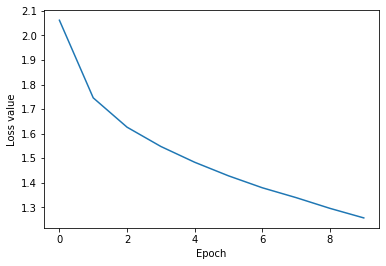

In [205]:
import matplotlib.pyplot as plt

plt.plot(avg_losses_f)
plt.xlabel('Epoch')
plt.ylabel('Loss value')
plt.show()

creating a function that can sample an index from a probability array 


In [206]:
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

validate the model

In [207]:
# Define the start sentence
# sentence = 'i read in the news\nthat the average man\nplease kis'
sentence = 'i love the way you look at me \n when the end of'
variance = 0.25
generated = ''
original = sentence
window = sentence

for i in range(400):
    x = np.zeros((1, seq_length))
    for t, char in enumerate(window):
        x[0, t] = char_to_int[char] # Change the sentence to index vector shape (1,50)
        
    x_in = Variable(torch.LongTensor(x))
    pred = model(x_in)
    pred = np.array(F.softmax(pred, dim=1).data[0].cpu())
    next_index = sample(pred, variance)
    next_char = int_to_char[next_index] # index to char

    generated += next_char
    window = window[1:] + next_char # Update Window for next char predict
    
print(original + generated)

i put the new forgis on the g
i trap until the bloom stuck in love you
i can be back the way
i was little bells jingle bells jingle bells jingle bells jingle bells jingle bells jingle bells jingle bells jingle bells jingle bells jingle bells jingle bells jingle bells jingle bells jingle bells jingle bells jingle bells jingle bells jingle bells jingle bells jingle bells jingle bells jingle bells jingle bells jingle bells jingle bells jingle bells 


# Word Level LSTM

In [173]:
data1 = data
data1 = data1[data1['genre'] == 'Country'].sample(1000)
data1['lyrics']= data1['lyrics'].apply(preprocessText)
print(data1.head())
print(data1.shape)

        Unnamed: 0  Unnamed: 0.1          artist    genre  \
34718        54000         54000      gary-allan  Country   
49759        76703         76703  dierks-bentley  Country   
196786      299852        299852     del-mccoury  Country   
178688      271499        271499   blake-shelton  Country   
228283      347184        347184   dwight-yoakam  Country   

                                       title  \
34718   red lips blue eyes little white lies   
49759                         breathe you in   
196786                           blue darlin   
178688                                buzzin   
228283              heartaches by the number   

                                                   lyrics language  
34718   red lips blue eyes and little white lies\noh d...       en  
49759   i've never been the kind\nto bear my heart and...       en  
196786  i was a fool broke every rule blue darlin'\nsa...       en  
178688  work work work man that's all i ever do\nbeen ...       en  

In [174]:
import re
newlines = re.sub("\n", " \n ", data1['lyrics'].str.cat(sep='\n').lower())
exclamation = re.sub("!", " ! ", newlines)
question = re.sub("!", " ! ", exclamation)
DP_text = re.findall(r'\S+|\n', question)
print('corpus length:', len(DP_text))

corpus length: 41965


In [175]:
# Counting characters appeared in all lyrics
words = sorted(list(set(DP_text)))
print('total words:', len(words))

total words: 3416


In [176]:
# Create a dictionary of characters, see the index of characters.
char_to_int = dict((c, i) for i, c in enumerate(words))
int_to_char = dict((i, c) for i, c in enumerate(words))

In [177]:
seq_length = 10 # The sentence window size
step = 1 # The steps between the windows
sentences = []
next_chars = []

# Create Target and sentences window
for i in range(0, len(DP_text) - seq_length, step):
    # range from current index to sequence length charaters
    sentences.append(DP_text[i: i + seq_length])  
    next_chars.append(DP_text[i + seq_length]) # the next character
    
sentences = np.array(sentences)
next_chars = np.array(next_chars)

#Print Sentence Window and next charaters
print('Sentence Window')
print (sentences[:5])
print('Target characters')
print (next_chars[:5])
print('Number of sequences:', len(sentences))

Sentence Window
[['red' 'lips' 'blue' 'eyes' 'and' 'little' 'white' 'lies' '\n' 'oh']
 ['lips' 'blue' 'eyes' 'and' 'little' 'white' 'lies' '\n' 'oh' "darlin'"]
 ['blue' 'eyes' 'and' 'little' 'white' 'lies' '\n' 'oh' "darlin'" "i'm"]
 ['eyes' 'and' 'little' 'white' 'lies' '\n' 'oh' "darlin'" "i'm" 'a']
 ['and' 'little' 'white' 'lies' '\n' 'oh' "darlin'" "i'm" 'a' 'fool']]
Target characters
["darlin'" "i'm" 'a' 'fool' 'for']
Number of sequences: 41955


In [178]:
# transferring the character to index 
def getdata(sentences, next_chars):
    X = np.zeros((len(sentences),seq_length))
    y = np.zeros((len(sentences)))
    length = len(sentences)
    index = 0
    for i in range(len(sentences)):
        sentence = sentences[i]
        for t, char in enumerate(sentence):
            X[i, t] = char_to_int[char]
        y[i] = char_to_int[next_chars[i]]
    return X, y

In [179]:
train_x,train_y = getdata(sentences, next_chars)
print(train_x)
print('Shape of training_x:', train_x.shape)
print('Shape of training_y:', train_y.shape)

[[2297. 1657.  302. ... 1637.    0. 1995.]
 [1657.  302.  939. ...    0. 1995.  711.]
 [ 302.  939.  108. ... 1995.  711. 1446.]
 ...
 [1968. 3256. 2935. ... 3409. 1827. 2760.]
 [3256. 2935.  115. ... 1827. 2760. 2007.]
 [2935.  115.  115. ... 2760. 2007. 3409.]]
Shape of training_x: (41955, 10)
Shape of training_y: (41955,)


In [180]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

class Simple_LSTM(nn.Module):
    def __init__(self,n_vocab,hidden_dim, embedding_dim,dropout = 0.2):
        super(Simple_LSTM, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.embedding_dim = embedding_dim
        self.lstm = nn.LSTM(embedding_dim, hidden_dim,dropout = dropout,num_layers = 2)
        self.embeddings = nn.Embedding(n_vocab, embedding_dim)
        self.fc = nn.Linear(hidden_dim, n_vocab)
    
    def forward(self, seq_in):
        # for LSTM, input should be (Sequnce_length,batchsize,hidden_layer), so we need to transpose the input
        embedded = self.embeddings(seq_in.t()) 
        lstm_out, _ = self.lstm(embedded)
        # Only need to keep the last character 
        ht=lstm_out[-1] 
        out = self.fc(ht)
        return out

In [181]:
X_train_tensor = torch.tensor(train_x, dtype=torch.long)
Y_train_tensor = torch.tensor(train_y, dtype=torch.long)
print('Shape of training_x:', X_train_tensor.shape)
print('Shape of training_y:', Y_train_tensor.shape)

Shape of training_x: torch.Size([41955, 10])
Shape of training_y: torch.Size([41955])


In [182]:
from torch.utils.data import Dataset, DataLoader
train = torch.utils.data.TensorDataset(X_train_tensor,Y_train_tensor)
train_loader = torch.utils.data.DataLoader(train, batch_size = 128)

In [183]:
model = Simple_LSTM(len(words),256,256)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.002) # Using Adam optimizer

In [184]:
import time # Add time counter
avg_losses_f = []
n_epochs=30

for epoch in range(n_epochs):
    print("Epoch: ", epoch)
    start_time = time.time()
    model.train()
    loss_fn = torch.nn.CrossEntropyLoss()
    avg_loss = 0.
    for i, (x_batch, y_batch) in enumerate(train_loader):
        y_pred = model(x_batch)
        
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
        avg_loss+= loss.item()/len(train_loader)
        
    elapsed_time = time.time() - start_time 
    print('Epoch {}/{} \t loss={:.4f} \t time={:.2f}s'.format(
        epoch + 1, n_epochs, avg_loss, elapsed_time))
    
    avg_losses_f.append(avg_loss)    
    
print('All \t loss={:.4f} \t '.format(np.average(avg_losses_f)))

Epoch:  0
Epoch 1/30 	 loss=6.0139 	 time=42.96s
Epoch:  1
Epoch 2/30 	 loss=5.4188 	 time=43.45s
Epoch:  2
Epoch 3/30 	 loss=5.0359 	 time=45.12s
Epoch:  3
Epoch 4/30 	 loss=4.6644 	 time=44.71s
Epoch:  4
Epoch 5/30 	 loss=4.3228 	 time=43.96s
Epoch:  5
Epoch 6/30 	 loss=4.0040 	 time=44.74s
Epoch:  6
Epoch 7/30 	 loss=3.7435 	 time=44.47s
Epoch:  7
Epoch 8/30 	 loss=3.5237 	 time=45.03s
Epoch:  8
Epoch 9/30 	 loss=3.3254 	 time=44.79s
Epoch:  9
Epoch 10/30 	 loss=3.0551 	 time=45.51s
Epoch:  10
Epoch 11/30 	 loss=2.8179 	 time=45.56s
Epoch:  11
Epoch 12/30 	 loss=2.5704 	 time=46.11s
Epoch:  12
Epoch 13/30 	 loss=2.3102 	 time=45.18s
Epoch:  13
Epoch 14/30 	 loss=2.0775 	 time=42.21s
Epoch:  14
Epoch 15/30 	 loss=1.8780 	 time=41.97s
Epoch:  15
Epoch 16/30 	 loss=1.7266 	 time=41.70s
Epoch:  16
Epoch 17/30 	 loss=1.6032 	 time=41.97s
Epoch:  17
Epoch 18/30 	 loss=1.4649 	 time=42.46s
Epoch:  18
Epoch 19/30 	 loss=1.3454 	 time=42.58s
Epoch:  19
Epoch 20/30 	 loss=1.2401 	 time=42.76s

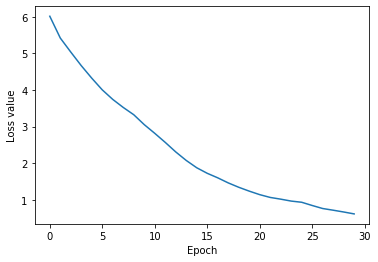

In [185]:
import matplotlib.pyplot as plt

plt.plot(avg_losses_f)
plt.xlabel('Epoch')
plt.ylabel('Loss value')
plt.show()

In [186]:
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [188]:
# Define the start sentence
# sentence = 'i read in the news\nthat the average man\nplease kis'
sentence = ["i", "remember", "dad", "walking", "out", "that", "door", "\n", "but", "i"]
variance = .5
generated = []
original = sentence
window = sentence

for i in range(400):
    x = np.zeros((1, seq_length))
    for t, char in enumerate(window):
        x[0, t] = char_to_int[char] # Change the sentence to index vector shape (1,50)
        
    x_in = Variable(torch.LongTensor(x))
    pred = model(x_in)
    pred = np.array(F.softmax(pred, dim=1).data[0].cpu())
    next_index = sample(pred, variance)
    next_char = int_to_char[next_index] # index to char

    generated = generated + [next_char]
    window = window[1:] + [next_char] # Update Window for next char predict
    
print(" ".join(original + generated))

i remember dad walking out that door 
 but i know the power of a song when you would have to try 
 he's not someone from the scene 
 but from the crowd let me rest and dream awhile say be home 
 and shows my lady down the moon 
 he took her off the block take 
 put a little love in your heart each and every love you say 
 id walk in home 
 chorus 
 now just just love that goodbye old friend farewell it took 
 but when you hold me when you punch that way 
 when i know the power of a song 
 when a song hits you right 
 poured my soul into stories of day 
 when i truck on your tombstone 
 one thing that i would 
 do my happiness for me 
 next good love makes you leave 
 raise some hell or hit your knees 
 all i love you and i know why i said 
 i wanna know 
 if i could have you back again 
 time when i don't want 
 goodbye old friend farewell it seems 
 we'll dance again in my dreams 
 goodbye old friend farewell it seems 
 we'll dance again in my dreams 
 goodbye old friend farewell it s